#Experiment - degrade knowledge of e and i params and see if we can still pick up K35. Tough. some overlap but some transits out by >1-2 days (which is the ttv amplitude, so this is no better than a straight fuzzy bls). Add a fuzz factor dependent on how close binary is to eclipse? (i.e. how much potential there is for unknown inclinations to cause problems?) transit durations seem to cluster around similar values (0.2 and 0.5 here)- but predictions are not necessarily the correct cluster.

In [1]:
#can we find K34 while assuming basic values for the e and i parameters?
import copy
import numpy as np
import emcee
import corner
import matplotlib.pyplot as p
import astropy.units as u
import funcs

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [42]:
# Kepler 35
cb = funcs.CBSystem(m1 = 0.8877,f1 = 1.,m2 = 0.8094,f2 = 0.3941,
                    ab = 0.17617,r1 = 1.0284 * u.Rsun.to('au'),r2 = 0.7861 * u.Rsun.to('au'),
                    eb = 0.1421,ib = np.deg2rad(90.4238),wb = 1.507,
                    fb = 0.06543,
                    mp = 0.127 * u.Mjup.to('Msun'),ap = 0.60347,rp = 0.728 * u.Rjupiter.to('au'),ep = 0.042,
                    ip = np.deg2rad(90.76),wp = 1.1541,fp = 1.3069,
                    Wp = np.deg2rad(-1.24),
                    t0 = 2454965.8500)
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days
fp0 = 1.3069

print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)
print(p_p0)

timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi
dt = 0.02
t = np.arange(2454953,2456424,dt)


20.7316772617
131.43772562486816


In [43]:
# make the reference stacked light curve set

#tts = funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))
tts = funcs.reb_cb(cb,tmin=np.min(t),tmax=np.max(t))
tts_2,tds_2 = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
    
ok = tts[:,0] == 20
#ref_tts = tts[ok]
ref_tts = tts_2[tds_2>0]
ref_tds = tds_2[tds_2>0]

In [44]:
#degrading our knowledge (assume we know eb and wb):
#for now, radii left as we know them - this will change transit durations, and whether some marginal transits happen.

cb.ib = np.pi/2.
cb.ip = np.pi/2.
cb.Wp = 0.0
cb.ep = 0.0
#cb.wp left as is because it defines f_p
cb.mp = 0.0



In [45]:
#now scan across m2/m1, m1+m2, p_p, f_p, as if we were searching.
mratset = np.linspace(cb.m2/cb.m1*0.9,cb.m2/cb.m1*1.1,21)
mtotset = np.linspace(cb.m2+cb.m1*0.9,cb.m1+cb.m2*1.1,5)
ppset = np.linspace(p_p0*0.97,p_p0*1.03,101)
fpset = np.linspace(cb.fp*0.98,cb.fp*1.02,11)

dt = 0.02
t = np.arange(2454953,2456424,dt)

print(mtotset[2])
print(mratset[10])

1.693185
0.911794525177


In [46]:
tts_all = {}
tds_all = {}

#horrible for loop filling in a 7 fold dict of dicts
for mrat in mratset:
    print(mrat)
    if mrat not in tts_all.keys():
        tts_all[mrat] = {}
        tds_all[mrat] = {}
        
    for mtot in mtotset:
        cb.m2 = mtot / (1 + 1./mrat)
        cb.m1 = mtot / (1 + mrat)
        cb.ab = ab0 * ( (cb.m1+cb.m2)/mb0 )**(1/3.) #force pb to be fixed

        if mtot not in tts_all[mrat].keys():
            tts_all[mrat][mtot] = {}
            tds_all[mrat][mtot] = {}
            
        for pp in ppset:
            cb.ap = ( mtot * (pp/365.25)**2 )**(1./3.)
  
            if pp not in tts_all[mrat][mtot].keys():
                tts_all[mrat][mtot][str(pp)[:6]] = {}
                tds_all[mrat][mtot][str(pp)[:6]] = {}  
                
            for fp in fpset:
                cb.fp = fp
                     
                ttimes, tdurs = funcs.reb_cb_dvm(cb, 0, 2, tmin=np.min(t), 
                                                tmax=np.max(t), timing_precision=timing_precision)
                            
                tts_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]] = ttimes[tdurs>0]
                tds_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]] = tdurs[tdurs>0]

0.82061507266
0.829733017911
0.838850963163
0.847968908415
0.857086853667
0.866204798919
0.87532274417
0.884440689422
0.893558634674
0.902676579926
0.911794525177
0.920912470429
0.930030415681
0.939148360933
0.948266306185
0.957384251436
0.966502196688
0.97562014194
0.984738087192
0.993856032443
1.0029739777


In [39]:
print(tts_all[0.30140679013758848][0.88199375000000002].keys())
cb.ab

dict_keys(['221.93', '222.06', '222.20', '222.34', '222.48', '222.62', '222.76', '222.90', '223.04', '223.17', '223.31', '223.45', '223.59', '223.73', '223.87', '224.01', '224.14', '224.28', '224.42', '224.56', '224.70', '224.84', '224.98', '225.12', '225.25', '225.39', '225.53', '225.67', '225.81', '225.95', '226.09', '226.22', '226.36', '226.50', '226.64', '226.78', '226.92', '227.06', '227.19', '227.33', '227.47', '227.61', '227.75', '227.89', '228.03', '228.17', '228.30', '228.44', '228.58', '228.72', '228.86', '229.00', '229.14', '229.27', '229.41', '229.55', '229.69', '229.83', '229.97', '230.11', '230.25', '230.38', '230.52', '230.66', '230.80', '230.94', '231.08', '231.22', '231.35', '231.49', '231.63', '231.77', '231.91', '232.05', '232.19', '232.33', '232.46', '232.60', '232.74', '232.88', '233.02', '233.16', '233.30', '233.43', '233.57', '233.71', '233.85', '233.99', '234.13', '234.27', '234.41', '234.54', '234.68', '234.82', '234.96', '235.10', '235.24', '235.38', '235.51',

0.22431

In [47]:
#make statistic from transit times and durs

timediffs = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
durdiffs = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
losttransits = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
overlap = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
                   
#horrible for loop
for imr,mrat in enumerate(mratset):
    for imt,mtot in enumerate(mtotset):
        for ipp,pp in enumerate(ppset):
            for ifp,fp in enumerate(fpset):
                
                #check against ref_tts
                #save difference, in tts and tds, across all transits. 
                #save number of transits lost (or gained)
                diff = 0
                ddiff = 0
                tlost = 0
                for ref_tt,ref_td in zip(ref_tts,ref_tds):
                    tts = tts_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]]
                    tds = tds_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]]
                    if np.min(np.abs(tts - ref_tt)) < pp/4.: #then we have a transit
                        tidx = np.argmin(np.abs(tts - ref_tt))
                        diff += np.abs(ref_tt - tts[tidx])
                        ddiff += np.abs(ref_td - tds[tidx])
                        olap = np.min([ref_tt+ref_td/2.,tts[tidx]+tds[tidx]/2.]) - np.max([ref_tt-ref_td/2.,tts[tidx]-tds[tidx]/2.])
                        if olap < 0: olap = 0
                        #calculate fraction of overlap with reference
                        overlap[imr,imt,ipp,ifp] += olap  
                    else:
                        tlost +=1
                        
                timediffs[imr,imt,ipp,ifp] = diff / (len(ref_tts)-tlost) #inf if we miss them all
                durdiffs[imr,imt,ipp,ifp] = ddiff / (len(ref_tts)-tlost)
                losttransits[imr,imt,ipp,ifp] = tlost        
                    
                
                

In [50]:
print(ref_tts)
tt = tts_all[0.91179452517742487][mtotset[3]][str(ppset[50])[:6]][str(fpset[5])[:6]]
print(tt)
print(ref_tds)
td = tds_all[0.91179452517742487][mtotset[3]][str(ppset[50])[:6]][str(fpset[5])[:6]]
print(td)

#print(ref_tts-tt)
print(overlap[10,3,50,5])
print(timediffs[10,3,50,5])
#losttransits[10,3,49,:]
#durdiffs[10,3,49,:]
#np.max(overlap)
print(np.diff(ref_tts))
print(np.sum(ref_tds))

[ 2455332.87041014  2455460.2174625   2455586.42187743  2455712.356026
  2455838.3220782   2455964.64963706  2456092.50592814]
[ 2455072.20951499  2455198.84127592  2455329.67232589  2455459.07441866
  2455585.51963483  2455711.46048926  2455837.28836015  2455963.23409157
  2456089.6703666   2456218.62154127  2456349.92037559]
[ 0.48850902  0.23723435  0.181051    0.17016807  0.18964684  0.25943775
  0.54551647]
[ 0.22339258  0.36881325  1.36919379  0.322064    0.20863371  0.17670599
  0.17635963  0.20659173  0.31025502  1.13568969  0.37543158]
0.0
1.63196178725
[ 127.34705236  126.20441494  125.93414857  125.96605219  126.32755886
  127.85629109]
2.07156350789


0.147241023968


<IPython.core.display.Javascript object>


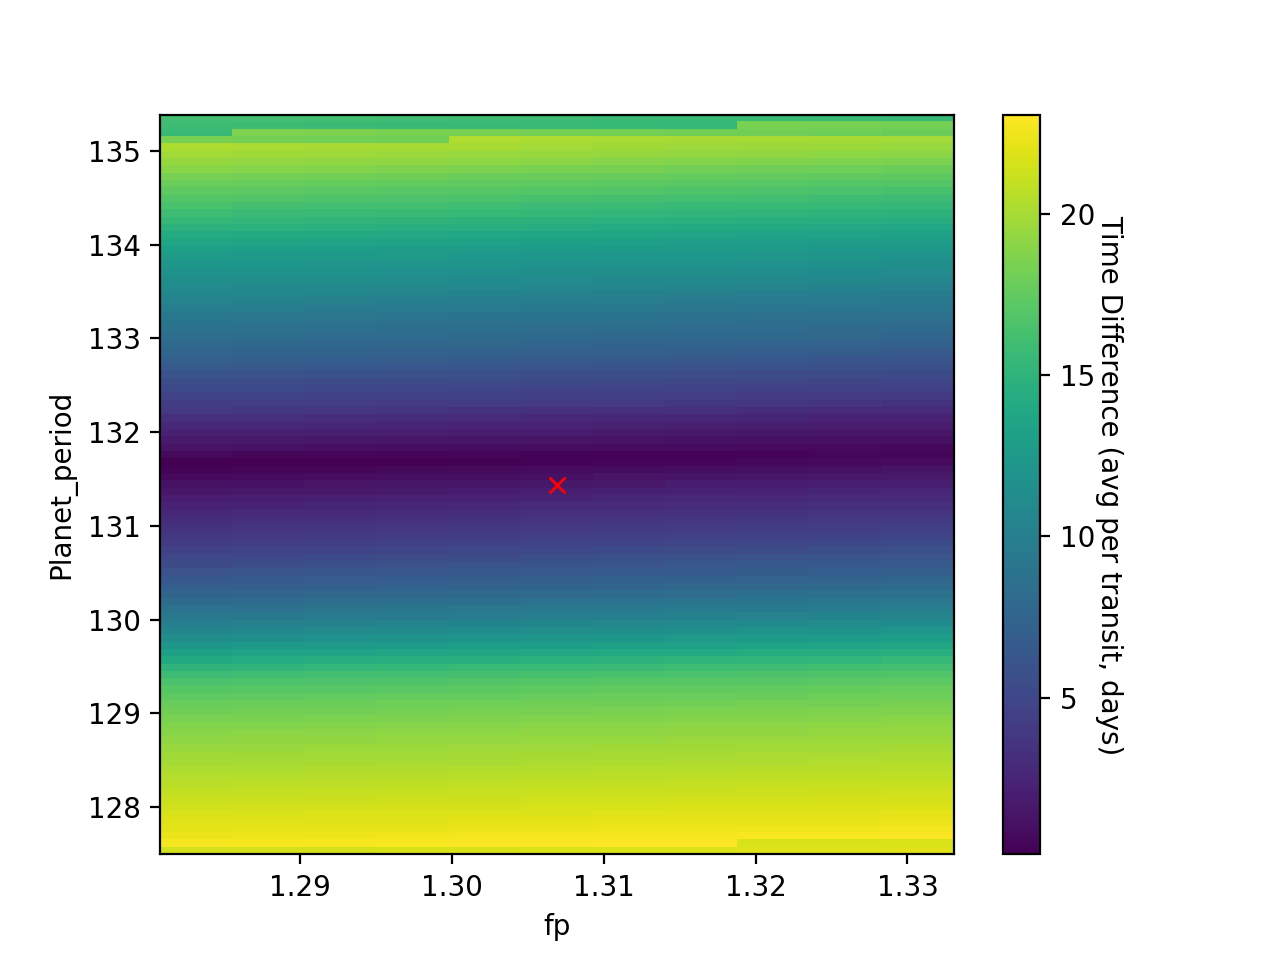

<IPython.core.display.Javascript object>


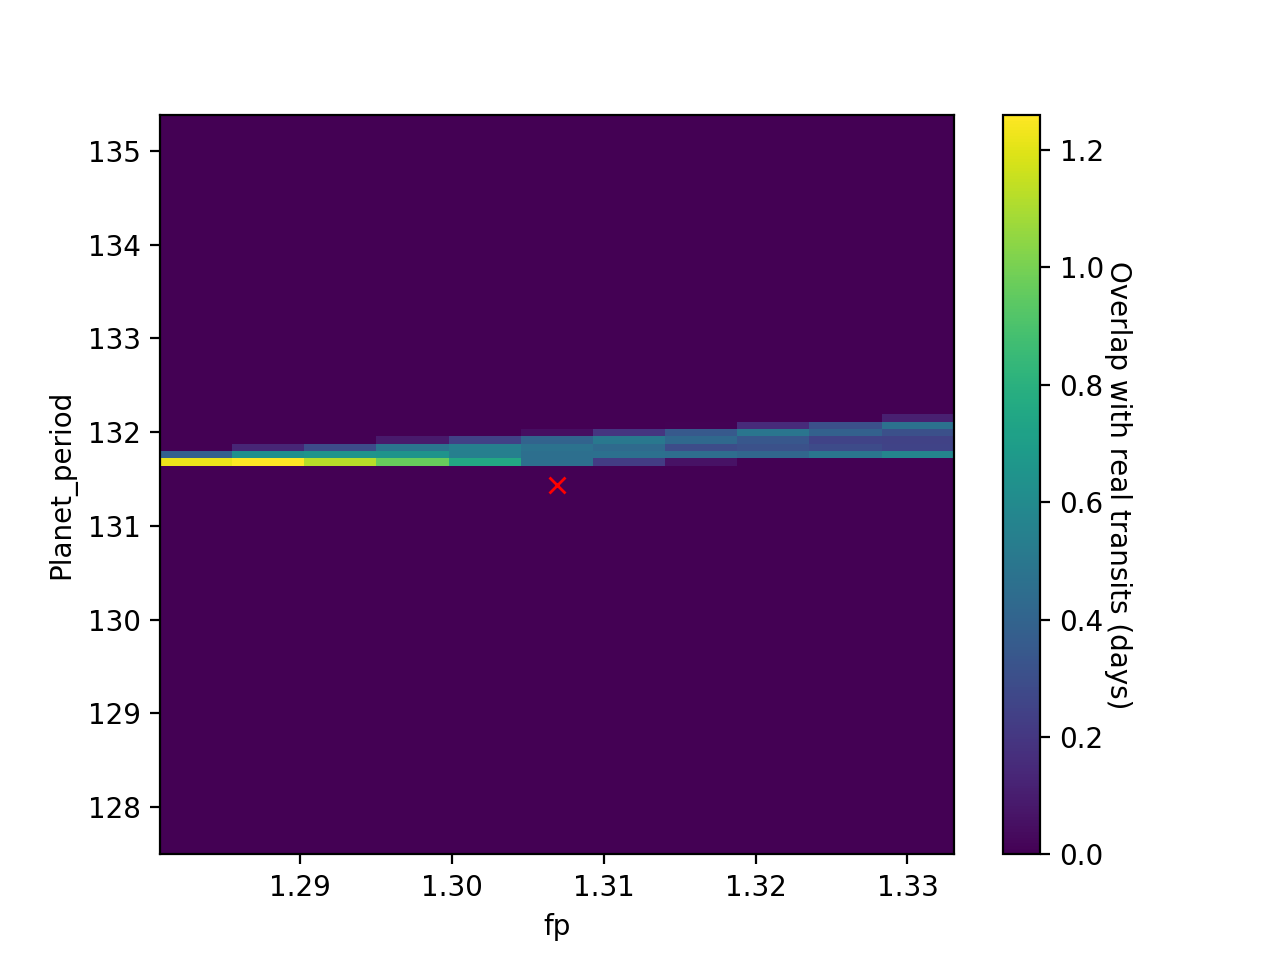

In [49]:
mratidx = 10
mtotidx = 2

print(np.min(timediffs[mratidx,mtotidx,:,:]))
#plots
p.figure()
palette = p.cm.viridis
p.imshow(timediffs[mratidx,mtotidx,:,:],origin='lower',
         extent=[np.min(fpset),np.max(fpset),np.min(ppset),np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Time Difference (avg per transit, days)', rotation=270, labelpad=10)
p.ylabel('Planet_period')
p.xlabel('fp')
p.plot(fp0,p_p0,'rx')

p.figure()
palette = p.cm.viridis
p.imshow(overlap[mratidx,mtotidx,:,:],origin='lower',
         extent=[np.min(fpset),np.max(fpset),np.min(ppset),np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Overlap with real transits (days)', rotation=270, labelpad=10)
p.ylabel('Planet_period')
p.xlabel('fp')
p.plot(fp0,p_p0,'rx')
